In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
np.random.seed(206)
import theano
import theano.tensor as tt
import sys
sys.path.insert(0, "../../..")
import pymc3 as pm

In [2]:
def plot_cov(X, K):
    x = X.flatten()
    fig = plt.figure(figsize=(16,5))
    ax1 = fig.add_subplot(121)
    m = ax1.imshow(K, cmap="viridis"); plt.colorbar(m)
    ax2 = fig.add_subplot(122)
    ax2.plot(x, K[:,0], "k", lw=2, alpha=0.8)

# Some covariance functions / kernels

## Exponentiated Quadratic

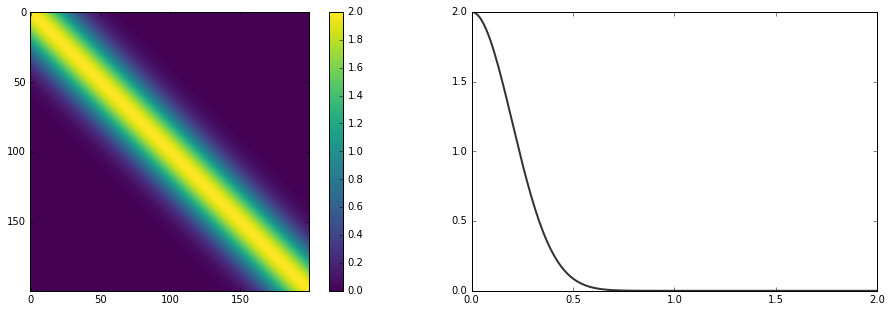

In [3]:
with pm.Model() as model:
    l = 0.2 
    tau = 2.0 
    cov_eq = tau * pm.gp.cov.ExpQuad(1, l)

X = np.linspace(0,2,200)[:,None]
K_eq = theano.function([], cov_eq.K(X))()

plot_cov(X, K_eq)

## Rational Quadratic

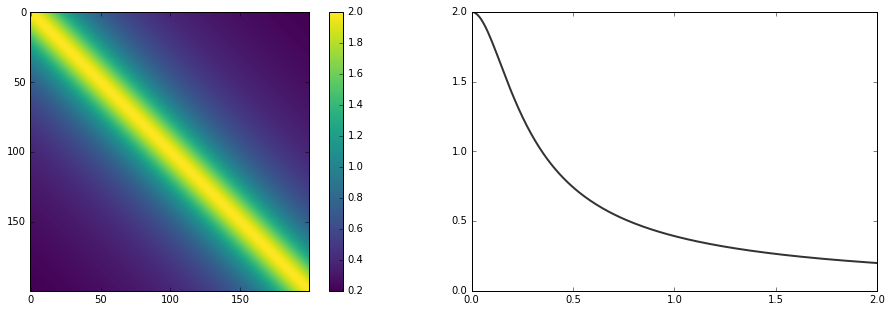

In [4]:
with pm.Model() as model:
    alpha=0.5
    cov_rq = tau * pm.gp.cov.RatQuad(1, l, alpha)

K_rq = theano.function([], cov_rq.K(X))()

plot_cov(X, K_rq)

## Exponential

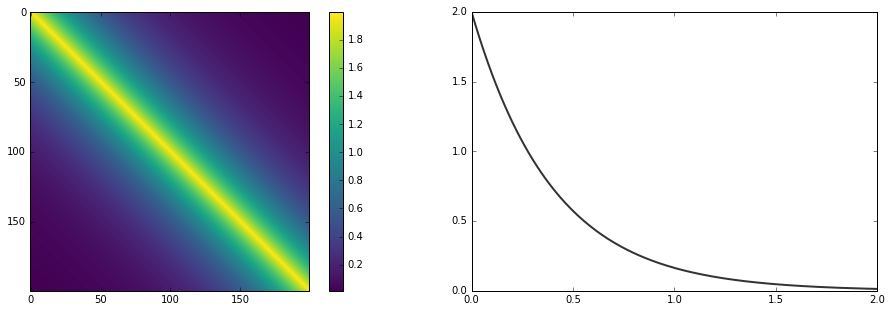

In [5]:
with pm.Model() as model:
    cov_exp = tau * pm.gp.cov.Exponential(1, l)

K_exp = theano.function([], cov_exp.K(X))()

plot_cov(X, K_exp)

## Matern 5/2

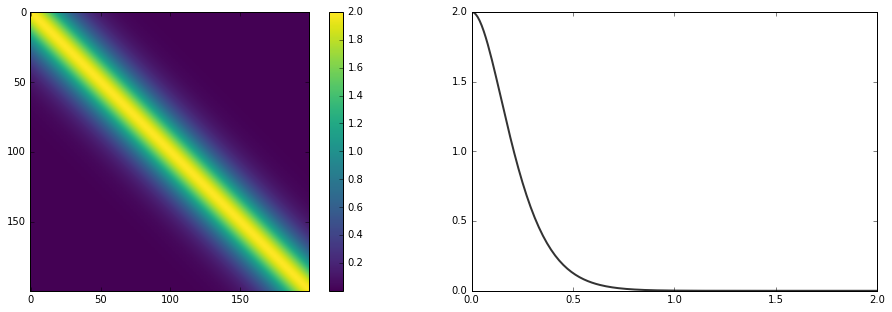

In [6]:
with pm.Model() as model:
    cov_m52 = tau * pm.gp.cov.Matern52(1, l)

K_m52 = theano.function([], cov_m52.K(X))()

plot_cov(X, K_m52)

## Matern 3/2

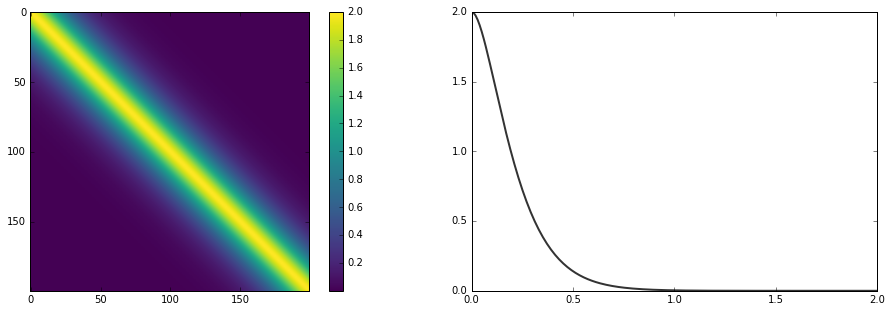

In [7]:
with pm.Model() as model:
    cov_m32 = tau * pm.gp.cov.Matern32(1, l)

K_m32 = theano.function([], cov_m32.K(X))()

plot_cov(X, K_m32)

# Cosine

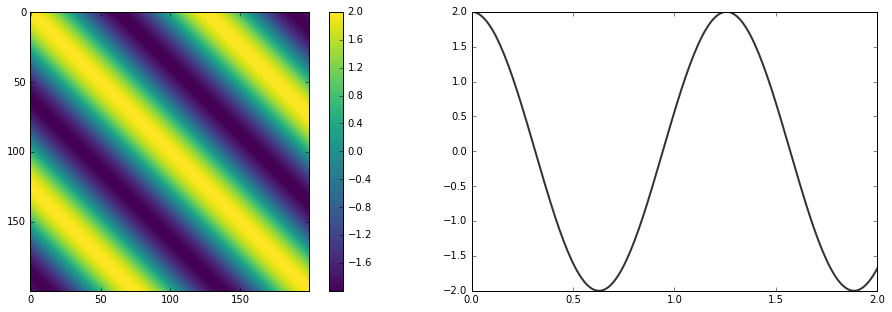

In [8]:
with pm.Model() as model:
    cov_cos = tau * pm.gp.cov.Cosine(1, l)

K_cos = theano.function([], cov_cos.K(X))()

plot_cov(X, K_cos)

# Linear

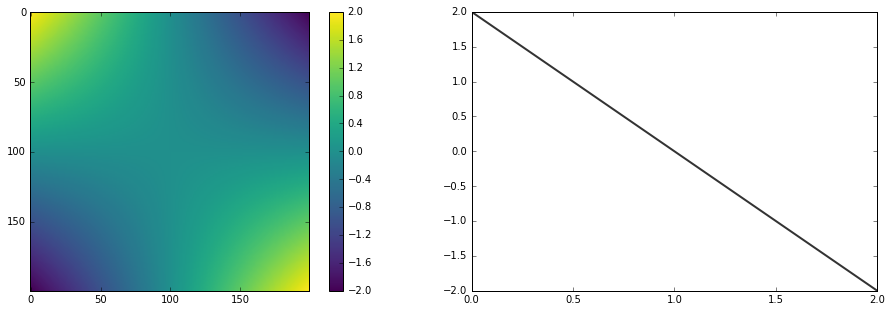

In [9]:
center = 1
with pm.Model() as model:
    cov_lin = tau * pm.gp.cov.Linear(1, center)

K_lin = theano.function([], cov_lin.K(X))()

plot_cov(X, K_lin)

# Multiplication with a precomputed covariance matrix 

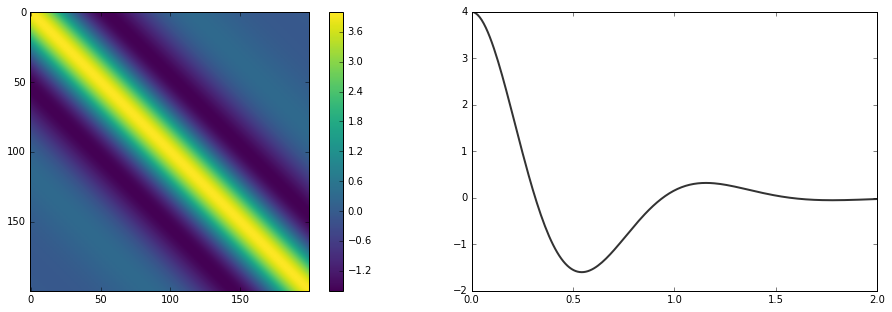

In [10]:
with pm.Model() as model:
    cov_fix = tau * pm.gp.cov.Matern32(1, 0.5) * cov_cos
    
K_fix = theano.function([], cov_fix.K(X))()
plot_cov(X, K_fix)

# Applying an arbitary warping function on the inputs

If $k(x, x')$ is a valid covariance function, then so is $k(w(x), w(x'))$.

The warping function can have unknown parameters.

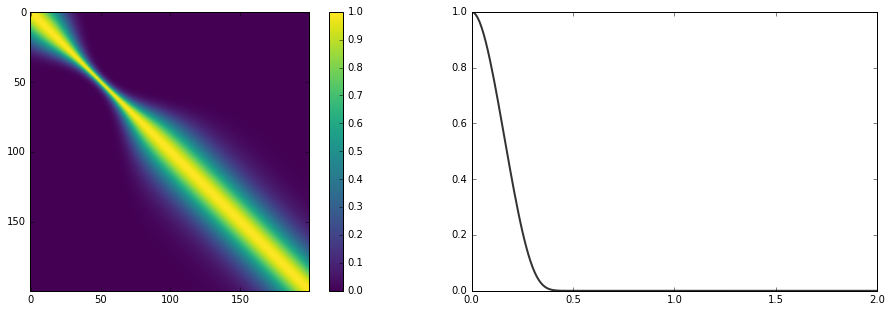

In [11]:
def warp_func(x, a, b, c):
    return x + (a * tt.tanh(b * (x + c)))

with pm.Model() as model:
    a = 1.0
    b = 6.0
    c = -0.5
    
    cov_m52 = pm.gp.cov.Matern52(1, l)
    cov_warp = pm.gp.cov.WarpedInput(1, warp_func=warp_func, args=(a,b,c), cov_func=cov_m52)
    
K_warp = theano.function([], cov_warp.K(X))()
plot_cov(X, K_warp)

# Covariance function via explicit basis 

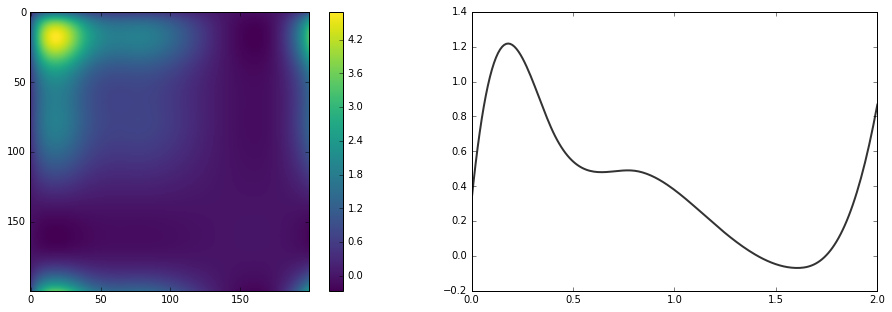

In [12]:
import patsy as pt
basis = np.array(pt.dmatrix("bs(x, 7)", {"x": X}))

with pm.Model() as model:
    alpha = np.random.randn(8,1)
    cov_bas = pm.gp.cov.BasisFuncCov(1, basis=basis, alpha=alpha)

K_bas = theano.function([], cov_bas.K(X))()
plot_cov(X, K_bas)